# Customers & Companies: A Data Exploration Project
By: Gavin Williams

Please see 'Assumptions' at the end of the workbook prior to reviewing.

Import functions that will need to be utilized to manipulate and analyze the data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import 'Customer' Dataset

Let's import the 'customer' data set which is stored as a csv file:

In [2]:
customer_df = pd.read_csv('customers.csv')

In [3]:
# returns first 5 rows of the dataframe
customer_df.head(5)

,id,age,gender,email,business_nature,company,position,payment_method,name,targets
0,0,26,Male,gmail.com,Communications,NaN,customer service officer,A,John__melgarejo,20670.07;20632.81;20722.58;20332.79;20662.55
1,1,31,Male,ymail.com,Government,NaN,助理客戶服務主管,A,William___kerne,31551.75;32431.83
2,2,26,Male,yahoo.com.hk,Retail / Wholesale,NaN,店務員,A,James___kadner,21686.08;21282.62;21566.40
3,3,52,Male,gmail.com,Other,NaN,MANAGER,NaN,Charles__MUHL,26055.26;26039.48;25986.92
4,4,22,Male,gmail.com,Retail / Wholesale,NaN,sales,A,george___baridon,15950.31


Let's gather some general information on the customer_df dataframe:

In [4]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9189 entries, 0 to 9188
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               9189 non-null   int64 
 1   age              9189 non-null   int64 
 2   gender           8874 non-null   object
 3   email            9012 non-null   object
 4   business_nature  8978 non-null   object
 5   company          8906 non-null   object
 6   position         8914 non-null   object
 7   payment_method   5865 non-null   object
 8   name             9189 non-null   object
 9   targets          9104 non-null   object
dtypes: int64(2), object(8)
memory usage: 718.0+ KB


In viewing the information on the customer_df dataframe, its evident that there is missing data for a majority of the fields. The fields 'id', 'age', and 'name' are the only fields without missing data. Missing data is represented by the undefined value, NaN. These undefined values will be remediated in the following lines of code.

Before beginning to cleanse the data, let's verify the field 'id' is primary key of the dataframe. This is important in case this dataframe would need to be joined to others. Note, the primary key for each customer record must be unique.

In [5]:
customer_df['id'].is_unique

True

Since the above line of code evaluates to True and there are no undefined values, we could confidently use this field as the primary key in the future.

# Creating 'Data_Cleaner' Class & Cleansing Customer Dataset

To expedite the process in cleansing this and future customer dataframes, let's create the class "Data_Cleaner" in which the constructor (__init__) will be initialized with a Pandas dataframe. Within this class, there are the following methods:

1. fill_nan: method that replaces undefined values in the dataframe's series with a defined value
2. remove_underscore: helper method that removes empty strings in a list
3. cleanse_customer_name: method that removes delimiters and separates a single name column into two, first and last name
4. target_converter_iloc: method that converts a column of 'targets' (or other values) into lists of values
5. remove_space_upper: method that removes uneeded trailing/leading spaces in a string and uppercases all characters

In [6]:
class Data_Cleaner:
    def __init__(self, my_dataframe):
        self.my_dataframe = my_dataframe
        
    def fill_nan(self, column, value = 'unknown'):
        """Replaces undefined values in a dataframe's series with a defined value
        
        :param column (series): Pandas series in which undefined values will be replaced
        :param value: value that will replace undefined values in the series. Default is the string - 'unknown'
        :returns: Updated series with undefined values replaced
        """
        self.my_dataframe[column] = self.my_dataframe[column].fillna(value = value)
    
    def remove_underscore(self, x):
        """Removes empty strings in a list. Note, this is to be utilized as a helper function for the class function,
        cleanse_customer_name, and should not be called directly.
        
        :param x (list): index of a Pandas series
        :returns: a series with empty strings removed from list objects at each index
        """
        res = [i for i in x if i.strip()]
        return res
        
    def cleanse_customer_name(self, column, delimiter = '_'):
        """Cleanses customer names by removing delimiters and separating into two columns, first_name and last_name
        
        :param column (series): Pandas series of names that will be cleansed
        :param delimiter (str): delimiter that the input name series will be split on. Default is a single underscore, '_'
        :returns: Updated dataframe with two series, first_name and last_name. Note, the original series is removed 
        from the dataframe.
        """        
        self.my_dataframe[column] = self.my_dataframe[column].str.split(delimiter)
        self.my_dataframe[column] = self.my_dataframe[column].apply(self.remove_underscore)
        first_last_name = pd.DataFrame(self.my_dataframe[column].tolist(), columns = ['first_name', 'last_name'])
        self.my_dataframe = pd.concat(objs = [self.my_dataframe, first_last_name], axis = 1)
        self.my_dataframe = self.my_dataframe.drop(column, axis = 1)
        self.my_dataframe['first_name'] = self.my_dataframe['first_name'].str.capitalize()
        self.my_dataframe['last_name'] = self.my_dataframe['last_name'].str.capitalize()
    
    
    def target_converter_iloc(self, column):
        """Converts target column from a string of values to a list of floats for customer record aggregation and analysis
        
        :param column (series): Pandas series of target values that will be converted to a list of floats
        :returns: Updated series of targets as a list of floats. Any undefined records are converted to an empty list, []       from the dataframe.
        """
        col_indx = self.my_dataframe.columns.get_loc(column)
        
         # splits each row's column_name value
        self.my_dataframe[column] = self.my_dataframe[column].str.split(';')
        
        # outer loop ensures the entire series will be iterated over
        for i in range(len(self.my_dataframe[column])):
            
            # first change, checking if it's NaN by comparing it to itself (if x != x, x is NaN)
            if self.my_dataframe.iloc[i, col_indx] != self.my_dataframe.iloc[i, col_indx]:
                
                # next change, using df.iat
                self.my_dataframe.iat[i, col_indx] = []
            else:
                for target in range(len(self.my_dataframe[column][i])):
                    self.my_dataframe.iloc[i, col_indx][target] = float(self.my_dataframe.iloc[i, col_indx][target])
        return self.my_dataframe[column]
    
    
    def remove_space_upper(self, column):
        """Cleans strings by removing leading/trailing spaces and makes all characters uppercase
                
        :param column (series): Pandas series of strings to be cleansed
        :returns: Updated series of strings cleansed
        """
        self.my_dataframe[column] = self.my_dataframe[column].str.split()
        self.my_dataframe[column] = self.my_dataframe[column].apply(lambda x: ' '.join(map(str, x)))
        self.my_dataframe[column] = self.my_dataframe[column].str.upper()

In [7]:
Data_Cleaner

__main__.Data_Cleaner

The customer_df dataframe will be passed into the class, Data_Cleaner, to create a new dataframe object of the class. The class methods will be applied to clean up the data prior to aggregation and analysis.

First, let's replace the undefined values in some of the columns:

In [8]:
# creates dataframe object of Data_Cleaner class
customer_df_new = Data_Cleaner(customer_df)

# replaces NaN values in the dataframe
customer_df_new.fill_nan('gender')
customer_df_new.fill_nan('business_nature')
customer_df_new.fill_nan('company')
customer_df_new.fill_nan('position')
customer_df_new.fill_nan('payment_method')

Second, let's split the feature 'name' into two features: first and last name:`

In [9]:
# splits 'name' feature
customer_df_new.cleanse_customer_name('name')

customer_df_new.my_dataframe[['first_name', 'last_name']]

,first_name,last_name
0,John,Melgarejo
1,William,Kerne
2,James,Kadner
3,Charles,Muhl
4,George,Baridon
...,...,...
9184,Cammie,Fashaw
9185,Rollie,Schrantz
9186,Carmen,Autobee
9187,Claudie,Helie


Next, let's clean up columns "company" and "business_nature":

In [10]:
# cleans up columns by removing leading/trailing spaces and uppercasing
customer_df_new.remove_space_upper('company')
customer_df_new.remove_space_upper('business_nature')
customer_df_new.remove_space_upper('position')

Finally, let's split the ‘target list’ feature to extract the values of all the ‘target’ values and create three aggregated features from the list of target values (Mean, SD, Count). Recall: all 'target' values that are undefined will be replaced by an empty list, [ ].

In [11]:
customer_df_new.target_converter_iloc('targets')

0       [20670.07, 20632.81, 20722.58, 20332.79, 20662...
1                                    [31551.75, 32431.83]
2                           [21686.08, 21282.62, 21566.4]
3                          [26055.26, 26039.48, 25986.92]
4                                              [15950.31]
                              ...                        
9184                                                   []
9185                                                   []
9186                                                   []
9187                                                   []
9188                                                   []
Name: targets, Length: 9189, dtype: object

In [12]:
# calculates mean of target values for each customer record
customer_df_new.my_dataframe['target_mean'] = pd.DataFrame(data = customer_df_new.my_dataframe['targets'].values.tolist()).mean(axis = 1)

# calculates count of target values for each customer record
customer_df_new.my_dataframe['target_count'] = pd.DataFrame(data = customer_df_new.my_dataframe['targets'].values.tolist()).count(axis = 1)

# calculates standard deviation of target values for each customer record
# df.std() parameter ddof = 0 is used to calculate each row's targets population stdev and handle dividing by zero
customer_df_new.my_dataframe['target_stdv'] = pd.DataFrame(data = customer_df_new.my_dataframe['targets'].values.tolist()).std(axis = 1, ddof = 0)

In [13]:
customer_df_new.my_dataframe.loc[5:10, ['company', 'first_name', 'last_name', 'targets', 'target_mean', 'target_stdv', 'target_count']]

,company,first_name,last_name,targets,target_mean,target_stdv,target_count
5,UNKNOWN,Anna,Muhn,"[13301.2, 13455.24, 13296.57]",13351.003333,73.730687,3
6,UNKNOWN,Frank,Muhn,"[22549.32, 22471.3, 22271.52, 22174.17]",22366.577500,150.348094,4
7,UNKNOWN,Joseph,Jeannette,"[11900.57, 11887.24, 11861.63]",11883.146667,16.158536,3
8,UNKNOWN,Emma,Muha,[13702.91],13702.910000,0.000000,1
9,CUICO FLORIST LIMITED,Elizabeth,Thomaston,"[25819.65, 25758.61]",25789.130000,30.520000,2
10,SINCERE FINANCE HOLDING LIMITED,Thomas,Melgarejo,"[20523.5, 20420.91, 20466.45]",20470.286667,41.969966,3


In viewing the dataframe slice above, notice the feature 'name' has ben separated into two columns - 'first_name' and 'last_name' - and the series 'targets' has been converted into lists with floats. The new 'targets' format allows for the following aggregations to be performed: target_mean, target_stdv, and target_count. These aggregations are included as the last three series of the dataframe. 

Columns such as 'company' have been trimmed and uppercase, so they can be aggregated in later steps if needed (e.g.; ' CUICO ' != 'CUICO' and 'cuico' != 'Cuico').

# Address Abnormal Customer in Customer Dataset

Before we begin to analyze the data and create visualizations, there are a few last things to do. First, we'll create a deep copy of the original dataframe so any changes are not reflected in the original.

In [14]:
# creates a deep copy of the original dataframe so any changes to the copy are not reflected in original
cust_df_copy_2 = customer_df_new.my_dataframe.copy(deep = True)

Second, let's drop customer record id = 8419, Lyda Kadner. Kadner has a 'target_mean' value that is ~990K higher than the next highest customer by 'target_mean', Louie Grindstaff.

In [15]:
cust_df_copy_2.nlargest(n = 3, columns = 'target_mean')

,id,age,gender,email,business_nature,company,position,payment_method,targets,first_name,last_name,target_mean,target_count,target_stdv
8419,8419,54,Female,123.com,OTHER,迪士尼,樂園服務,unknown,[991898262.6],Lyda,Kadner,9.918983e+08,1,0.000000
7129,7129,56,Male,NaN,OTHER,怡富中港物流有限公司,BOSS,unknown,"[714431.35, 724552.68]",Louie,Grindstaff,7.194920e+05,2,5060.665000
7131,7131,44,Female,hotmail.com,OTHER,怡彩集團有限公司,自僱美容,B,"[432182.57, 424819.03, 424477.13, 430278.01]",Lucia,Muhl,4.279392e+05,4,3361.458414


Maintaining her record in the dataset would skew our visualizations. Consider how her record skews the visualization below. Note, Kadner is 54 years old.

Text(0.5, 0, 'Age')

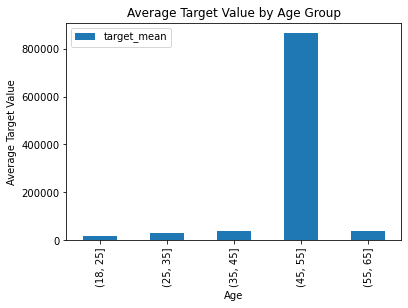

In [16]:
age = pd.cut(x = cust_df_copy_2['age'], bins = [18, 25, 35, 45, 55, 65])
age_target = cust_df_copy_2.pivot_table(values = 'target_mean', index = [age])

age_target.plot.bar()
plt.title('Average Target Value by Age Group')
plt.ylabel('Average Target Value')
plt.xlabel('Age')

By dropping her record, the graph above would appear as so:

Text(0.5, 0, 'Age')

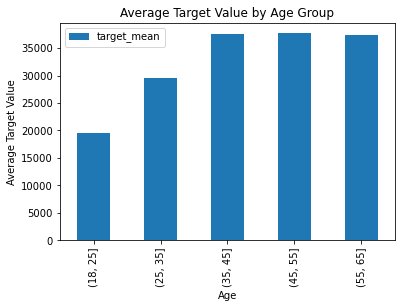

In [17]:
# removes Kadner from dataset
cust_df_copy_2 = cust_df_copy_2.drop(labels = 8419)

age = pd.cut(x = cust_df_copy_2['age'], bins = [18, 25, 35, 45, 55, 65])
age_target = cust_df_copy_2.pivot_table(values = 'target_mean', index = [age])

age_target.plot.bar()
plt.title('Average Target Value by Age Group')
plt.ylabel('Average Target Value')
plt.xlabel('Age')

# Summarize the 'Customer' Dataset

Now that the customer dataset has been cleansed and aggregate values have been created (e.g.; target_mean), we can begin to analyze and summarize our findings.

Let's analyze the data by approaching it from a high-level. We'll take the following top-down approach from the aggregate to customer level:

    1. Analysis of data by business nature (e.g.; Top Target Values by Industry)
    2. Analysis of data by payment method (e.g.; Breakdown of Payment Methods among Customers)
    3. Analysis of data by age generation of customers (e.g.; Average Target Value by Age Bin)
    4. Analysis of data by gender (e.g.; % Total Targets by Gender)
    5. Analysis of data by customer (e.g.; Top N Customers by Average Target Value)

-------------------------------------------------------------------------------------------------------------------------------

1. Analysis of Data by Business Nature/Industry: Breakdown of Total Target Value by Industry

In [18]:
# creates a pivot table with the sum of targets (avg. by customer), and the % of total for each business_nature (aka industry)
business_tbl = pd.pivot_table(cust_df_copy_2[['business_nature', 'target_mean']], index = ['business_nature'], aggfunc = 'sum')
business_tbl['%_target'] = (business_tbl['target_mean']/business_tbl['target_mean'].sum())*100

# renames columns
business_tbl.columns = ['sum_targets', '%_targets']

# returns the top N industries in descending order based on shared % of total target value among all industries 
business_tbl = business_tbl.nlargest(n = 10, columns = '%_targets')
business_tbl

,sum_targets,%_targets
business_nature,,
OTHER,3.173979e+07,11.428550
RETAIL / WHOLESALE,2.784890e+07,10.027558
CONSTRUCTION,2.418136e+07,8.706987
FOOD SERVICES,2.251894e+07,8.108400
BANK / FINANCE,1.925308e+07,6.932461
TRANSPORTATION,1.512843e+07,5.447295
GOVERNMENT,1.395627e+07,5.025237
IT,1.228342e+07,4.422893
PROFESSIONAL SERVICES / CONSULTATION,1.084715e+07,3.905733


In viewing the pivot table above, you can notice the industry, "Other", represents the largest share in the total target value (avg. target at customer level). Since "Other" is arbitrary, the dataset could be enhanced by assinging customers' with an industry of "Other" an actual industry; this point will be touched on in the summary section of the notebook.

Let's now graph the total targets for each industry to see the data visually:

Text(0.5, 1.0, 'Total Target Value by Business Nature')

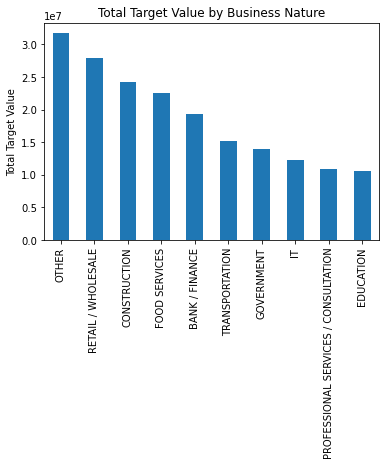

In [19]:
business_tbl_slice = business_tbl['sum_targets']
business_tbl_slice.plot.bar()
plt.ylabel('Total Target Value')
plt.xlabel('')
plt.title('Total Target Value by Business Nature')

Besides the "Other" category, it's apparent that a majority of the customers are aligned with the "Retail / Wholesale" industry based on the total target value among industries. However, other industries like "Food Services" follow closely behind indicating that the customer base is broad and diversified.

-------------------------------------------------------------------------------------------------------------------------------

2. Analysis by Payment Method

Using the feature/column "payment_method", let's try to understand how the client's customers are paying. While we do not have ample information on what payment method means, we may be able to make some inferences based on the results. We will create a pie chart to understand the breakdown among the different payment methods customers use.

In [20]:
# creates and returns a groupby object for count of payment methods
df_payment = cust_df_copy_2.groupby('payment_method')['payment_method'].count()

In [21]:
df_payment

payment_method
A          4347
B           771
C           747
unknown    3323
Name: payment_method, dtype: int64

Text(0.5, 1.0, 'Customer Payment Method Breakdown')

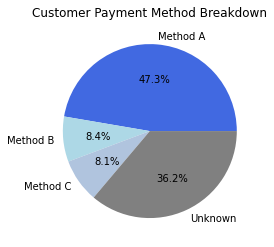

In [22]:
# creates labels and colors that will be applied to the eventual pie chart
pay_labels = ['Method A', 'Method B', 'Method C', 'Unknown']
pay_colors = ['royalblue','lightblue','lightsteelblue','gray']

# creates pie chart and formats slice values as one decimal point %'s
plt.pie(x = df_payment, labels = pay_labels, autopct = '%1.1f%%', colors = pay_colors)
plt.title('Customer Payment Method Breakdown')

Viewing the pie chart above, nearly 50% (4347) of the customers are paying the client using payment method A. Payment methods B and C share 16% of transaction types at 1518. A little over a third of the customers in the dataset do not have an assigned payment method and appear as 'Unknown'.

--------------------------------------------------------------------------------------------------------------------------------

3. Analysis by Age Generation: Average Target Value by Age Group

Now, let's analyze the customer base by age group. We'll use a bar chart to depict the average target value by age generation. This will give us better insight into demographics and how age correlates with activity:

Text(0.5, 0, 'Age')

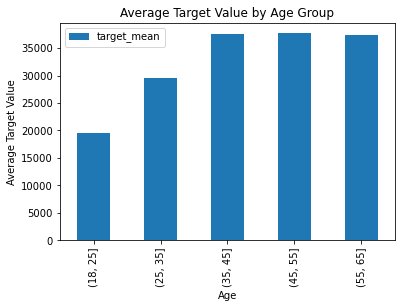

In [59]:
# print('Oldest Customer:', cust_df_copy_2['age'].nlargest(n = 1)) <-- confirmed oldest customer is 65
# print('Youngest Customer:', cust_df_copy_2['age'].nsmallest(n = 1)) <-- confirmed youngest customer is 18

# age variable creates bins for customer age ranges
age = pd.cut(x = cust_df_copy_2['age'], bins = [18, 25, 35, 45, 55, 65])
age_target = cust_df_copy_2.pivot_table(values = 'target_mean', index = [age])

age_target.plot.bar()
plt.title('Average Target Value by Age Group')
plt.ylabel('Average Target Value')
plt.xlabel('Age')

Viewing the chart above, its evident that clients 35 years and older represent the most active customers based on average target value by age range.

-------------------------------------------------------------------------------------------------------------------------------

4. Analysis of Data by Gender: % Total Targets by Gender

Let's now visualize the customer base by gender to further investigate the demographics of the problem set. We'll breakdown each gender's percentage (%) share in total target value among the dataset:

In [60]:
# generates a pivot table and applies the aggregate function 'sum' to the feature 'target_mean'
gender_tbl = pd.pivot_table(cust_df_copy_2[['gender', 'target_mean']], index = ['gender'], aggfunc = 'sum')

# creates a new series in the dataframe for each gender's percent of total
gender_tbl['%_target'] = (gender_tbl['target_mean']/gender_tbl['target_mean'].sum())*100

# renames the columns
gender_tbl.columns = ['sum_targets', '%_targets']

gender_tbl

,sum_targets,%_targets
gender,,
Female,5.938649e+07,21.383304
Male,2.131290e+08,76.741400
unknown,5.208143e+06,1.875297


In the pivot table above, we can see that male customers represent ~77% of total targets while females represent ~21%. Males representing more than three quarters of total targets is substantial and could provide guidance on future decisions.

-------------------------------------------------------------------------------------------------------------------------------

5. Analysis of Data by Customer: Top 10 Customers by Average Target Value

Finally, let's analyze the data at the lowest level, by customer. We'll create a horizontal bar chart that will show the the top 10 customers based on average target value.

Text(0.5, 0, 'Average Target Value')

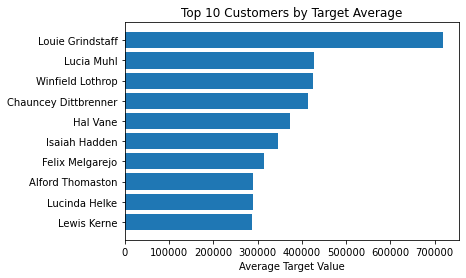

In [25]:
# creates new column 'full_name'
cust_df_copy_2['full_name'] = cust_df_copy_2[['first_name', 'last_name']].apply(' '.join, axis = 1)

# returns top 10 customers by 'target_mean'
top_targets = cust_df_copy_2[['full_name', 'target_mean']].nlargest(n = 10, columns = 'target_mean')

# orders top 10 customers by 'target_mean' in descending order
top_targets.sort_values(by = 'target_mean', inplace = True)

plt.barh(top_targets['full_name'], top_targets['target_mean'])
plt.title('Top 10 Customers by Target Average')
plt.xlabel('Average Target Value')

Viewing the horizontal bar chart above, it appears that the customer Louie Grindstaff represents the top customer by average target value. Grindstaff's average is nearly double the next customer, Lucia Muhl. This raises a question - is this an instance of another anamoly in the data or is Grindstaff an exceptional customer? Given the margin between Grindstaff and the nearest customer is not as great as Lyda Kadner's (customer removed from dataset), we'll retain Grindstaff in the dataset.

# Summary of Customers: Inferences, Improvements, & Extensions 

After having analyzed the customer dataset, we can infer the following:

1. Customers aligned with the industry "Retail / Wholesale" represent the largest share in total target value at ~10% (excluding "Other") with other industries following close behind.
    - Other industries following closely behind indicates that the customer base is broad and diversified. 
    - If we are to assume target value represents sales/revenue, the industry diversification can provide ample support in financial downturns.
    - A broad market footprint indicates there are potential growth opportunities among different markets.
    

2. Nearly 50%, or 4347, customers in the dataset utilize payment method A to pay the client. This is a substantial value and may allow us to make the following inference:
    - We could infer that payment method A represents a transactional method with favorable terms, such as low transaction 
       fees or low interest rates (if the product/service is procured on credit).

  Unfortunately, a little over a third of the customers in the dataset do not have an assigned payment method and appear as 
  'Unknown' after having applied the Data_Cleaner method. This suggests one or more of the following:
    - There is missing data.
    - Customers are using a payment method that is not included as an option in the customer questionnaire.
    - Missing values may represent transactions using hard currency (dollars, shekels, etc.) as opposed to a digital exchange,
    and thus are not tracked/recorded.


3. Customers 35 years and older represent the most active customers based on average target value by age range; males represent ~77% of the total value in targets. 
    - Without information on the product or service customers are purchasing, it is difficult to make any major inferences. For example, if we had more information on the product/service, we could determine if marketing to more females is a good financial decision. 
    - If the customer database is oriented around corporate sales (aka B2B), older males dominating the customer dataset is 
    indicative of the corporate world. 
    - To expound further, procurement/purchasing and supply chain functions in organizations do tend to skew towards older men. This could explain the findings.
    
    

4. The customer Louie Grindstaff represents the top customer by average target value

There are multiple ways this dataset could be improved. A non-exhaustive list includes:

- Create a more explicit column name for the feature, "target".
    - It is NOT clear what this column represents. 
    - Do target values represent customer spend? Spend by month, quarter, or year? Or does target represent something for Accounts Payable such as the amount a customer owes the client in a certain pay period?
    
    
- If the column "target" represents monetary values, there needs to be another column to indicate the currency of each record's target values. There are a number of Chinese customers in the dataset. Are their target values in Yuan, or have they been converted to USD?
    
 
- Cleanse features and ensure tabs (\t), new lines (\n) are removed from cells. This WILL impact aggreagation results if they are not caught


- Nice to have: utilize the googletrans API to translate company names and other values not in English (or the preferred language), or request the customers to submit suitable translations. Since the dataset has a large number of records and googleTrans caps the number of API calls, I am unable to translate the entire set. The client could translate features of the dataset by doing one of the following:
    1. Calling the API on multiple batches of the dataset, each of which would be at or under googleTrans' threshold for the
    number of API calls.
    2. Converting the feature into one string, translating the entire string, separating the string, and returning a translated 
    series.
    3. Paying for Google's service which shouldn't include a cap on the number of API calls

If I could, I would take the following features from the web to improve the dataset:

1. Business Function of the Customer
    - If possible, having the business function for record (Engineering, Finance, HR, etc.) would allow the owner of the dataset to determine how best to approach his/her customers.
    - This data could likely be sourced from LinkedIn or another professional social media site and related to the data based on the full name and company of the employee
    - One caveat/limitation we could face is the lack of automation. This particular data may not exist in a database and could require manual input. This required labor may not justify sourcing the data.


2. Geographic Location
    - The geographic location of the employee, or employee's company, would be useful in understanding the past/current domestic and geographical breakdown of the customer base. This data could help inform region-based marketing and pricing strategies (assuming the "targets" are sales/revenue data).
    - Sourcing the geographic location for each company would be relatively easy, and there likely exists a database with company headquarters. This data could be related to the customer dataset using the company names.
    - One caveat/limitation we could face is the ability to source data at the customer level. While it is easy to determine the location of companies, it is not easy to determine an employee's location. Company location may not be useful. For example, if John Smith works for a multi-national corporation, his job location may not be the company's main HQ. Due to regional disparities, we cannot assume two customers of the same company but different locations will interact the same with the product/service (assuming the "targets" are sales/revenue data).


3. Additional Consumer Purchase Data
    - Assuming targets represent sales/revenue data, relating other customer purchase data to the dataset could be valuable in developing strategies around market entry and future product/service development.
    - One caveat/limitation is the sensitivity and cost (both financial and reputational) of sourcing this data. Data security, safety and integrity is critical to maintaining a brand image.

# Import 'Company' Dataset

Let's import the 'company' data set which is stored as an Excel file:

In [26]:
company_df = pd.read_excel('companies.xlsx')
company_df

,company_id,name,domain,business_nature,employee_number,type,market_cap
0,"""00123122""",HSBC,www.hsbc.com/,banking,226059,public,78.45billion
1,878434523,AIA,www.aia.com,insurance,0,public,1.12T
2,3423656,MTR,http://www.mtr.com.hk/en/customer/main/index.html,Railway,28035,public,271B
3,452352,PCCW,http://www.pccw.com/,communications,22800,public,31.6001B
4,4342ff34,HKT,hkt.com,Telecom,"""15900.00""",public,$80.45B
5,534534,Manulife,https://www.manulife.com/,insurance,34000,public,$47.4 billion
6,232131,Cathay Pacific Airways,www.cathaypacific.com,airline,35000,public,$42.29 B
7,123555342,Hong Kong Police Force,https://www.police.gov.hk,law enforcement,36681,government,NaN
8,621621320,KPMG,home.kpmg,consulting,227000,NaN,NaN
9,998411df,HAECO,www.haeco.com,\tAerospace,16641,public,NaN


Let's gather some general information on the company_df dataframe:

In [27]:
company_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   company_id       11 non-null     object
 1   name             11 non-null     object
 2   domain           11 non-null     object
 3   business_nature  11 non-null     object
 4   employee_number  11 non-null     object
 5   type             10 non-null     object
 6   market_cap       8 non-null      object
dtypes: object(7)
memory usage: 744.0+ bytes


In viewing the information on the company_df dataframe, its evident that there is missing data for a two of the fields: 'type' and 'market_cap'. Missing data is represented by the undefined value, NaN. These undefined values will be remediated in the following lines of code.

Before beginning to cleanse the data, let's verify the field 'id' is primary key of the dataframe. This is important in case this dataframe would need to be joined to others. Note, the primary key for each company record must be unique.

In [28]:
company_df['company_id'].is_unique

True

Since the above line of code evaluates to True and there are no undefined values, we could confidently use this field as the primary key in the future.

# Utilizing the 'Data_Cleaner' Class to Cleanse the 'Company' Dataset

To expedite process in cleansing the company dataframe, let's leverage some of the methods from the already defined "Data_Cleaner" class:

In [29]:
# passes company_df to create an object of the 'Data_Cleaner' class
comp_df = Data_Cleaner(company_df)

First, let's replace undefined values, remove trailing/leading spaces, and uppercase series elements within the dataframe:

In [30]:
# replaces undefined elements in series
comp_df.fill_nan('type')
comp_df.fill_nan('market_cap')

# removes trailing/leading spaces and uppercases strings
comp_df.remove_space_upper('name')
comp_df.remove_space_upper('business_nature')
comp_df.remove_space_upper('type')

Let's take a look at the dataframe now:

In [31]:
comp_df.my_dataframe

,company_id,name,domain,business_nature,employee_number,type,market_cap
0,"""00123122""",HSBC,www.hsbc.com/,BANKING,226059,PUBLIC,78.45billion
1,878434523,AIA,www.aia.com,INSURANCE,0,PUBLIC,1.12T
2,3423656,MTR,http://www.mtr.com.hk/en/customer/main/index.html,RAILWAY,28035,PUBLIC,271B
3,452352,PCCW,http://www.pccw.com/,COMMUNICATIONS,22800,PUBLIC,31.6001B
4,4342ff34,HKT,hkt.com,TELECOM,"""15900.00""",PUBLIC,$80.45B
5,534534,MANULIFE,https://www.manulife.com/,INSURANCE,34000,PUBLIC,$47.4 billion
6,232131,CATHAY PACIFIC AIRWAYS,www.cathaypacific.com,AIRLINE,35000,PUBLIC,$42.29 B
7,123555342,HONG KONG POLICE FORCE,https://www.police.gov.hk,LAW ENFORCEMENT,36681,GOVERNMENT,unknown
8,621621320,KPMG,home.kpmg,CONSULTING,227000,UNKNOWN,unknown
9,998411df,HAECO,www.haeco.com,AEROSPACE,16641,PUBLIC,unknown


Index (0, 0), or 'company_id' = 00123122, is enclosed by quotes. The ID was likely enclosed in quotes by someone to avoid the leading zeros from being dropped during file conversions. Let's remove these quotes and convert the entire series to dtype string:

In [32]:
# corrects index (0,0)'s "company_id" to remove quotes
comp_df.my_dataframe.iloc[0,0] = comp_df.my_dataframe.iloc[0,0][1:-1] 
comp_df.my_dataframe

,company_id,name,domain,business_nature,employee_number,type,market_cap
0,00123122,HSBC,www.hsbc.com/,BANKING,226059,PUBLIC,78.45billion
1,878434523,AIA,www.aia.com,INSURANCE,0,PUBLIC,1.12T
2,3423656,MTR,http://www.mtr.com.hk/en/customer/main/index.html,RAILWAY,28035,PUBLIC,271B
3,452352,PCCW,http://www.pccw.com/,COMMUNICATIONS,22800,PUBLIC,31.6001B
4,4342ff34,HKT,hkt.com,TELECOM,"""15900.00""",PUBLIC,$80.45B
5,534534,MANULIFE,https://www.manulife.com/,INSURANCE,34000,PUBLIC,$47.4 billion
6,232131,CATHAY PACIFIC AIRWAYS,www.cathaypacific.com,AIRLINE,35000,PUBLIC,$42.29 B
7,123555342,HONG KONG POLICE FORCE,https://www.police.gov.hk,LAW ENFORCEMENT,36681,GOVERNMENT,unknown
8,621621320,KPMG,home.kpmg,CONSULTING,227000,UNKNOWN,unknown
9,998411df,HAECO,www.haeco.com,AEROSPACE,16641,PUBLIC,unknown


In [33]:
# converts feature "company_id" to strings
comp_df.my_dataframe['company_id'].apply(lambda x: str(x))

0      00123122
1     878434523
2       3423656
3        452352
4      4342ff34
5        534534
6        232131
7     123555342
8     621621320
9      998411df
10     df879987
Name: company_id, dtype: object

If we return the dataframe again, we notice the column 'company_id' is now corrected. However, index 4 of the feature 'employee_number' is in an improper format. Additionally, the feature 'market_cap' is a mix of strings and numbers. The following steps will correct the 'employee_number' and 'market_cap' features:

In [34]:
comp_df.my_dataframe

,company_id,name,domain,business_nature,employee_number,type,market_cap
0,00123122,HSBC,www.hsbc.com/,BANKING,226059,PUBLIC,78.45billion
1,878434523,AIA,www.aia.com,INSURANCE,0,PUBLIC,1.12T
2,3423656,MTR,http://www.mtr.com.hk/en/customer/main/index.html,RAILWAY,28035,PUBLIC,271B
3,452352,PCCW,http://www.pccw.com/,COMMUNICATIONS,22800,PUBLIC,31.6001B
4,4342ff34,HKT,hkt.com,TELECOM,"""15900.00""",PUBLIC,$80.45B
5,534534,MANULIFE,https://www.manulife.com/,INSURANCE,34000,PUBLIC,$47.4 billion
6,232131,CATHAY PACIFIC AIRWAYS,www.cathaypacific.com,AIRLINE,35000,PUBLIC,$42.29 B
7,123555342,HONG KONG POLICE FORCE,https://www.police.gov.hk,LAW ENFORCEMENT,36681,GOVERNMENT,unknown
8,621621320,KPMG,home.kpmg,CONSULTING,227000,UNKNOWN,unknown
9,998411df,HAECO,www.haeco.com,AEROSPACE,16641,PUBLIC,unknown


In [35]:
# indexes the 'employee_number' and takes a slice of its value to remove the quotes (" ")
comp_df.my_dataframe.loc[4, 'employee_number'] = comp_df.my_dataframe.loc[4, 'employee_number'][1:-4]

comp_df.my_dataframe.loc[4]

company_id         4342ff34
name                    HKT
domain              hkt.com
business_nature     TELECOM
employee_number       15900
type                 PUBLIC
market_cap          $80.45B
Name: 4, dtype: object

In [36]:
# converts feature 'employee_number' to int
comp_df.my_dataframe['employee_number'].apply(lambda x: int(x))

0     226059
1          0
2      28035
3      22800
4      15900
5      34000
6      35000
7      36681
8     227000
9      16641
10     41671
Name: employee_number, dtype: int64

Now, let's write a brief function with conditional statements to handle the feature 'market_cap':

In [37]:
def mkt_cap_converter(x):
    """Corrects market cap format (e.g.; '$7B' -> 7000000000000)
    
    :param x: string of company market cap
    :returns: market cap as dtype float
    """
    if x == 'UNKNOWN':
        return x
    if ('B' in x) or ('BILLION' in x):
        result = ''.join([i for i in x if i.isdigit() or i == '.'])
        result = float(result) * 1000000000
        return result
    if ('T' in x) or ('TRILLION' in x):
        result = ''.join([i for i in x if i.isdigit() or i == '.'])
        result = float(result) * 1000000000000
        return result

In [38]:
# removes trailing/leading spaces and capitalizes string
comp_df.remove_space_upper('market_cap')

# corrects market_cap feature by applying/calling mkt_cap_converter function above
comp_df.my_dataframe['market_cap'] = comp_df.my_dataframe['market_cap'].apply(mkt_cap_converter)

In [39]:
comp_df.my_dataframe

,company_id,name,domain,business_nature,employee_number,type,market_cap
0,00123122,HSBC,www.hsbc.com/,BANKING,226059,PUBLIC,78450000000.0
1,878434523,AIA,www.aia.com,INSURANCE,0,PUBLIC,1120000000000.0
2,3423656,MTR,http://www.mtr.com.hk/en/customer/main/index.html,RAILWAY,28035,PUBLIC,271000000000.0
3,452352,PCCW,http://www.pccw.com/,COMMUNICATIONS,22800,PUBLIC,31600100000.0
4,4342ff34,HKT,hkt.com,TELECOM,15900,PUBLIC,80450000000.0
5,534534,MANULIFE,https://www.manulife.com/,INSURANCE,34000,PUBLIC,47400000000.0
6,232131,CATHAY PACIFIC AIRWAYS,www.cathaypacific.com,AIRLINE,35000,PUBLIC,42290000000.0
7,123555342,HONG KONG POLICE FORCE,https://www.police.gov.hk,LAW ENFORCEMENT,36681,GOVERNMENT,UNKNOWN
8,621621320,KPMG,home.kpmg,CONSULTING,227000,UNKNOWN,UNKNOWN
9,998411df,HAECO,www.haeco.com,AEROSPACE,16641,PUBLIC,UNKNOWN


Viewing the company dataframe above, we can see that there are no longer any undefined fields and any outliers/missing values have been remediated. 

While the feature 'market_cap' may now be difficult to read, it is prepared for further analyzation. The unknown 'market_cap' for the company 'Hong Kong Police Force' is expected since it is a Chinese-owned organization and financial information is not public knowledge. However, 'KPMG' is a public company but does not have its market capitilization listed. Additionally, AIA's 'employee_number' is listed as zero. I will quickly correct these things before proceeding with the analysis of the data.

Note: the feature 'domain' does appear to have inconsistent values; however, since it is not critical to analyzing the data, it will remain untouched.

In [40]:
# corrects 'UNKNOWN' company type for KPMG
comp_df.my_dataframe.loc[8, 'type'] = 'PUBLIC'

# corrects 'HAECO' company type to private; it is not a public company based on my research
comp_df.my_dataframe.loc[9, 'type'] = 'PRIVATE'

# replaces 'UNKNOWN' market cap for KPMG today's (9/2) closing
comp_df.my_dataframe.loc[8, 'market_cap'] = 2320000000.0

# updates 'AIA' company's 'employee_number'
comp_df.my_dataframe.loc[1, 'employee_number'] = 23000

comp_df.my_dataframe

,company_id,name,domain,business_nature,employee_number,type,market_cap
0,00123122,HSBC,www.hsbc.com/,BANKING,226059,PUBLIC,78450000000.0
1,878434523,AIA,www.aia.com,INSURANCE,23000,PUBLIC,1120000000000.0
2,3423656,MTR,http://www.mtr.com.hk/en/customer/main/index.html,RAILWAY,28035,PUBLIC,271000000000.0
3,452352,PCCW,http://www.pccw.com/,COMMUNICATIONS,22800,PUBLIC,31600100000.0
4,4342ff34,HKT,hkt.com,TELECOM,15900,PUBLIC,80450000000.0
5,534534,MANULIFE,https://www.manulife.com/,INSURANCE,34000,PUBLIC,47400000000.0
6,232131,CATHAY PACIFIC AIRWAYS,www.cathaypacific.com,AIRLINE,35000,PUBLIC,42290000000.0
7,123555342,HONG KONG POLICE FORCE,https://www.police.gov.hk,LAW ENFORCEMENT,36681,GOVERNMENT,UNKNOWN
8,621621320,KPMG,home.kpmg,CONSULTING,227000,PUBLIC,2320000000.0
9,998411df,HAECO,www.haeco.com,AEROSPACE,16641,PRIVATE,UNKNOWN


# Summarize the 'Company' Dataset

Now that the company dataset has been cleansed, we can begin to analyze and summarize our findings.

Let's analyze the data through the following lenses:

    1. Analysis of data by company type (e.g.; Public versus Private Companies)
    2. Analysis of data by company size (e.g.; Market Capitilization)
    3. Analysis of data by company business nature/industry

-------------------------------------------------------------------------------------------------------------------------------

1. Analysis of Data by Company Type

In [41]:
# create a deep copy
comp_df_copy = comp_df.my_dataframe.copy(deep = True)

Text(0, 0.5, 'Number of Companies')

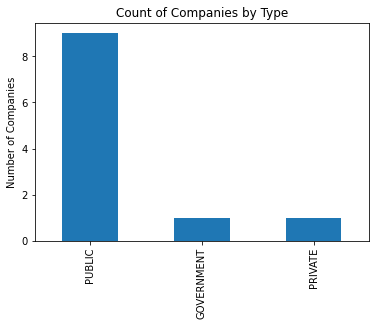

In [42]:
# creates count aggregation of companies by type
comp_type = comp_df_copy.groupby('type')['type'].count()

# sorts values in descending order
comp_type = comp_type.sort_values(ascending = False)

comp_type.plot.bar()
plt.title('Count of Companies by Type')
plt.xlabel('')
plt.ylabel('Number of Companies')

The bar chart above indicates the majority of the companies in the dataset are publically-traded corporations. Nine are public; one is government; and one is private.

-------------------------------------------------------------------------------------------------------------------------------

2. Analysis of Data by Company Size: Market Capitalization

Let's understand the sizes of the companies we are dealing with in the dataset. To perform this analysis, we'll remove companies with a market cap that is undefined and use the remaining companies to generate a horizontal bar chart. 

Text(0.5, 0, 'Market Capitalization')

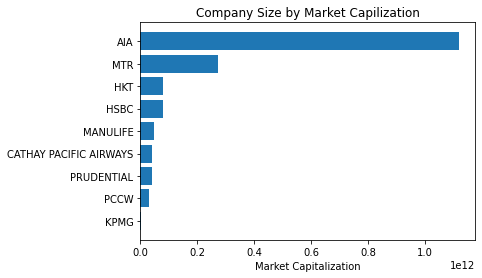

In [43]:
# boolean indexing to remove rows with a 'market_cap' that is undefined
x = comp_df_copy['market_cap'] != 'UNKNOWN'
comp_df_copy_2 = comp_df_copy[x]

comp_mktcap = comp_df_copy_2[['name', 'market_cap']]

comp_mktcap = comp_mktcap.sort_values('market_cap')
plt.barh(comp_mktcap['name'], comp_mktcap['market_cap'])
plt.title('Company Size by Market Capilization')
plt.xlabel('Market Capitalization')

Viewing the graph above, it is clearly evident that the Chinese insurance company AIA is the largest by market capitilization.

-------------------------------------------------------------------------------------------------------------------------------

3. Analysis of Data by Company Business Nature/Industry

In [44]:
# boolean indexing to remove rows with a 'market_cap' that is undefined
comp_df_copy = comp_df_copy[comp_df_copy['market_cap'] != 'UNKNOWN'].sort_values('market_cap')

# creates table with one column for the industry and one column for the industry's total market capitalization
comp_df_data = comp_df_copy.groupby('business_nature')['market_cap'].sum()/1000000000
comp_df_data.reset_index().sort_values(by = 'market_cap', ascending = False)

# determines the count of companies by industry
comp_ind_cnt = comp_df_copy.groupby('business_nature')['business_nature'].count()

comp_df_data = pd.concat([comp_df_data, comp_ind_cnt], axis = 1)
comp_df_data.columns = ['market_cap', 'count_companies']
comp_df_data.sort_values(by = 'market_cap', ascending = False)

,market_cap,count_companies
business_nature,,
INSURANCE,1207.89,3
RAILWAY,271.0,1
TELECOM,80.45,1
BANKING,78.45,1
AIRLINE,42.29,1
COMMUNICATIONS,31.6001,1
CONSULTING,2.32,1


In the table above, we can see that the industry 'Insurance' is the largest by market capitalization in the company dataset. Its value is representative of three insurance companies: AIA (1.1T), Manulife (47.4B), and Prudential (40.5B). Let's create a bar chart to see this data visually...

Text(0, 0.5, 'Market Cap (in USD Billions)')

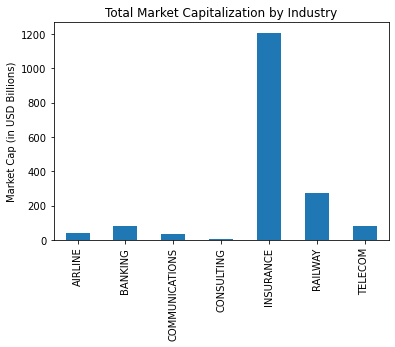

In [45]:
comp_df_data['market_cap'].plot.bar()
plt.title('Total Market Capitalization by Industry')
plt.xlabel('')
plt.ylabel('Market Cap (in USD Billions)')

# Summary of Companies: Inferences & Improvements

After having analyzed the companies dataset, we can infer the following:

1. 9 out of 11 companies in the dataset are public companies


2. The public Chinese insurance company AIA is the largest by market capitalization in the dataset at 1.12 T (assuming all market caps are in USD)


3. The insurance industry is the only business_nature in the dataset with multiple companies - three total. The insurance industry represents that largest by market capitalization in the company dataset and is representative of three companies: AIA (1.1T), Manulife (47.4B), and Prudential (40.5B).

There are multiple ways this dataset could be improved. A non-exhaustive list includes:

- Ensure the fields 'employee_id' and 'company_id' are stored as strings

- Store 'market_cap' as an integer or float, so aggregation and analysis can easily be performed on it

- Be consistent with the 'name' field. Some values are full companies names while others appear to be abbreviations or ticker symbols

- Ensure the employee field is stored as an integer or string representing an integer. The number of employees reported to be working for an organization is never fractional.

# Aggregate Customer Data into Companies Data

After having performed analyses on the customer and company datasets separately, let's combine data from both sets to gain greater insight. First, we need to determine the foreign and primary keys between both datasets to join them.

In [46]:
cust_df_copy_2.head(3)

,id,age,gender,email,business_nature,company,position,payment_method,targets,first_name,last_name,target_mean,target_count,target_stdv,full_name
0,0,26,Male,gmail.com,COMMUNICATIONS,UNKNOWN,CUSTOMER SERVICE OFFICER,A,"[20670.07, 20632.81, 20722.58, 20332.79, 20662...",John,Melgarejo,20604.16,5,138.736669,John Melgarejo
1,1,31,Male,ymail.com,GOVERNMENT,UNKNOWN,助理客戶服務主管,A,"[31551.75, 32431.83]",William,Kerne,31991.79,2,440.040000,William Kerne
2,2,26,Male,yahoo.com.hk,RETAIL / WHOLESALE,UNKNOWN,店務員,A,"[21686.08, 21282.62, 21566.4]",James,Kadner,21511.70,3,169.192317,James Kadner


In the sample above, it looks like the field 'company' from the customer dataset will be utilized to join it to 'name' in the company dataset. In this scenario, 'name' would be a primary key and 'company' a foreign key. Their relation is represented by a one to many relationship. In other words, there are one or more companies in the customer dataset for every single, unique company in the company dataset. 

Before we merge the datasets, let's perform aggregations on the 'customer' dataset using 'company' as the groupby field. We'll develop supportive visualizations from the these aggregations to tell a story.

Note: aggregations by company will be off of the 'target_mean', not 'targets' in an effort to smooth the data.

In [47]:
# groups by 'company' and peforms multiple aggregations on the field 'target_mean'
cust_df_slice = cust_df_copy_2.groupby('company')['target_mean'].aggregate(['count','sum','mean','max','min']).reset_index()

# groups by 'company' and peforms one aggregation on 'target_count'
cust_df_slice_2 = cust_df_copy_2.groupby('company')['target_count'].aggregate('sum').reset_index()

# merges the two groupby dataframes above
result = pd.merge(left = cust_df_slice, right = cust_df_slice_2, on = 'company')

# renames columns and returns the top 5 largest companies by 'sum_targets'
result.columns = ['company', 'total_employees','sum_targets','mean_target','max_target','min_target','count_targets']
result.nlargest(n = 5, columns = 'sum_targets')

,company,total_employees,sum_targets,mean_target,max_target,min_target,count_targets
4672,UNKNOWN,204,3.206055e+06,15715.957338,72159.250000,-1950.875000,627
2154,HSBC,41,2.052674e+06,50065.215333,230130.260000,13237.300000,110
2134,HOSPITAL AUTHORITY,28,1.741929e+06,62211.763315,290725.340000,15109.818000,88
143,AIA,22,9.996178e+05,45437.174667,112461.116667,15219.496667,67
2056,HONG KONG POLICE FORCE,15,8.260997e+05,55073.314767,152179.670000,14877.435000,39


Text(0.5, 0, 'Total Target Value')

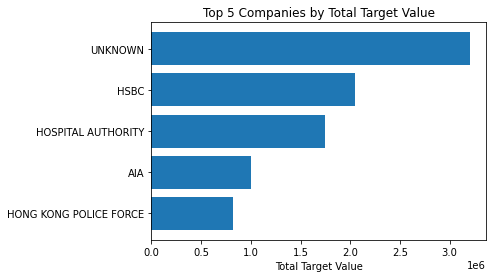

In [48]:
b = result[['company','sum_targets']].nlargest(n = 5, columns = 'sum_targets').sort_values(by = 'sum_targets')

plt.barh(b['company'], b['sum_targets'])
plt.title('Top 5 Companies by Total Target Value')
plt.xlabel('Total Target Value')

Viewing the top 5 companies by 'sum_targets' in table above, there appears to be three companies present from the 'company' dataset: HSBC, AIA, and Hong Kong Police Force. Among these three companies, HSBC has the highest 'sum_targets' and 'count_targets'.

Now, let's see how many employees work for the top 5 companies by total employees:

Text(0.5, 0, 'Number of Employees')

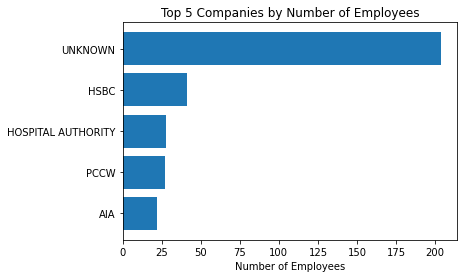

In [49]:
a = result[['company','total_employees']].nlargest(n = 5, columns = 'total_employees').sort_values(by = 'total_employees')

plt.barh(y = a['company'], width = a['total_employees'])
plt.title('Top 5 Companies by Number of Employees')
plt.xlabel('Number of Employees')

The graph clearly shows gaps in the data - over 200 employees do not have a company assigned to them.

# Dataset Merging

We are now ready to merge the aggregated company data from the 'customer' dataset with the 'company' dataset. Before merging, let's view the first two records of both datasets to understand what will be combined:

In [50]:
# sample from 'customer' dataset
result[result['company'] == 'KPMG']

,company,total_employees,sum_targets,mean_target,max_target,min_target,count_targets
2646,KPMG,8,297722.4125,37215.301563,52247.2175,13746.51,26


In [51]:
# need to create a new copy since some records with undefined values were removed earlier
comp_df_copy_3 = comp_df.my_dataframe.copy(deep = True)

# sample from 'company' dataset
comp_df_copy_3[comp_df_copy_3['name'] == 'KPMG']

,company_id,name,domain,business_nature,employee_number,type,market_cap
8,621621320,KPMG,home.kpmg,CONSULTING,227000,PUBLIC,2320000000.0


Recall that using the 'company' field from the 'customer' dataset and 'name' field from the 'company' dataset, we will be able to successfully merge both tables. We will perform an inner join on both tables and will need to specify both columns for the script to work.

In [52]:
# inner join with related columns specified
agg_company_df = comp_df_copy_3.merge(right = result, left_on = 'name', right_on = 'company')

# removes superfluous columns from the joined table
agg_company_df = agg_company_df.drop(labels = ['domain','company'], axis = 1)

agg_company_df

,company_id,name,business_nature,employee_number,type,market_cap,total_employees,sum_targets,mean_target,max_target,min_target,count_targets
0,00123122,HSBC,BANKING,226059,PUBLIC,78450000000.0,41,2.052674e+06,50065.215333,230130.260000,13237.300000,110
1,878434523,AIA,INSURANCE,23000,PUBLIC,1120000000000.0,22,9.996178e+05,45437.174667,112461.116667,15219.496667,67
2,3423656,MTR,RAILWAY,28035,PUBLIC,271000000000.0,20,5.083899e+05,25419.493733,50407.465000,13289.392000,64
3,452352,PCCW,COMMUNICATIONS,22800,PUBLIC,31600100000.0,27,6.941012e+05,25707.451321,55274.292000,15143.560000,91
4,4342ff34,HKT,TELECOM,15900,PUBLIC,80450000000.0,21,5.288780e+05,25184.668040,45573.666667,12711.643333,65
5,534534,MANULIFE,INSURANCE,34000,PUBLIC,47400000000.0,17,4.238329e+05,24931.345118,54885.790000,10058.813333,38
6,232131,CATHAY PACIFIC AIRWAYS,AIRLINE,35000,PUBLIC,42290000000.0,19,6.190651e+05,32582.375781,58091.250000,15253.050000,61
7,123555342,HONG KONG POLICE FORCE,LAW ENFORCEMENT,36681,GOVERNMENT,UNKNOWN,15,8.260997e+05,55073.314767,152179.670000,14877.435000,39
8,621621320,KPMG,CONSULTING,227000,PUBLIC,2320000000.0,8,2.977224e+05,37215.301563,52247.217500,13746.510000,26
9,998411df,HAECO,AEROSPACE,16641,PRIVATE,UNKNOWN,12,2.649501e+05,22079.176667,32233.472500,15907.095000,34


Great! All 11 companies from the 'company' dataset appear in the 'customer' dataset. Now, let's analyze the combined dataset the following ways:

    1. Analysis of Companies by Total Target Value
    2. Analysis of Companies and Employees
    3. Analysis of the Correlation between Different Values (e.g.; Total Target Value vs. Employees)

-------------------------------------------------------------------------------------------------------------------------------

1. Analysis of Companies by Total Target Value

Text(0.5, 0, 'Total Target Value')

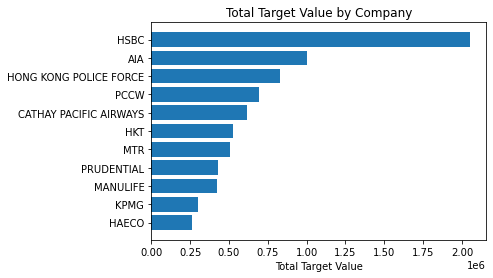

In [53]:
y = agg_company_df[['name', 'sum_targets']]
y = y.sort_values(by = 'sum_targets')
plt.barh(y['name'], y['sum_targets'])
plt.title('Total Target Value by Company')
plt.xlabel('Total Target Value')

The graph above shows that the company 'HSBC' has the largest total target value in the 'customer' dataset at ~20.5M. HSBC is also more than double the next highest company, 'AIA', in total target value.

-------------------------------------------------------------------------------------------------------------------------------

2. Analysis of Companies by Employees

Now that we have an idea of the companies and their total target values, let's try to find out how many employees each company has in the 'customer' dataset. We'll use boolean indexing to return those companies with greater than 20 employees.

In [54]:
# boolean indexing returns companies with more than 20 employees in the 'customer' dataset
x = agg_company_df['total_employees'] > 20
agg_company_df[x]

,company_id,name,business_nature,employee_number,type,market_cap,total_employees,sum_targets,mean_target,max_target,min_target,count_targets
0,00123122,HSBC,BANKING,226059,PUBLIC,78450000000.0,41,2.052674e+06,50065.215333,230130.260000,13237.300000,110
1,878434523,AIA,INSURANCE,23000,PUBLIC,1120000000000.0,22,9.996178e+05,45437.174667,112461.116667,15219.496667,67
3,452352,PCCW,COMMUNICATIONS,22800,PUBLIC,31600100000.0,27,6.941012e+05,25707.451321,55274.292000,15143.560000,91
4,4342ff34,HKT,TELECOM,15900,PUBLIC,80450000000.0,21,5.288780e+05,25184.668040,45573.666667,12711.643333,65


Viewing the table above, we can see that HSBC also has the most employees present in the 'customer' dataset. This suggests a positive correlation between 'total_employees' and 'sum_targets'. Let's create a scatter plot in the next step to validate this...

-------------------------------------------------------------------------------------------------------------------------------

3. Analysis of the Correlation between Different Values (e.g.; Total Target Value vs. Employees)

Text(0, 0.5, 'Total Target Value')

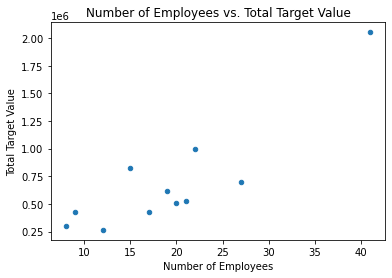

In [55]:
# creates a scatter plot of 'total_employees' vs. 'sum_targets'
agg_company_df.plot.scatter(x = 'total_employees',y = 'sum_targets')
plt.title('Number of Employees vs. Total Target Value')
plt.xlabel('Number of Employees')
plt.ylabel('Total Target Value')

The scatter plot above confirms that there is a positive correlation between the number of employees present in the 'customer' dataset and the total target value.

While we are here, let's quickly understand the correlation between 'market_cap' and 'sum_targets' and 'market_cap' and 'count_targets'

Text(0, 0.5, 'Total Target Value')

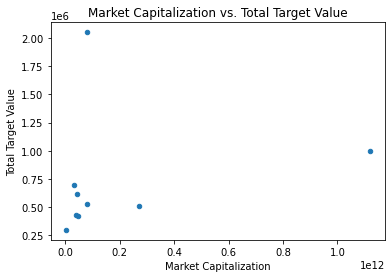

In [56]:
z = agg_company_df[agg_company_df['market_cap'] != 'UNKNOWN']

z.plot.scatter(x = 'market_cap', y = 'sum_targets')
plt.title('Market Capitalization vs. Total Target Value')
plt.xlabel('Market Capitalization')
plt.ylabel('Total Target Value')

Text(0, 0.5, 'Count of Targets')

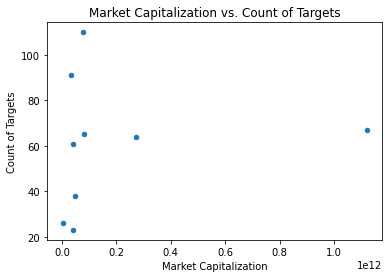

In [57]:
z.plot.scatter(x = 'market_cap', y = 'count_targets')
plt.title('Market Capitalization vs. Count of Targets')
plt.xlabel('Market Capitalization')
plt.ylabel('Count of Targets')

Based on the three scatter plots, we can conclude that market capitalization is not a good indicator of the total target value for each company. Instead, total target value is driven by the total number of customers for each company in the dataset.

In [58]:
plt.show()

# Summary of Companies & Customer Merge: Inferences 

After having analyzed the combined dataset, we can infer the following:

1. Although the company 'AIA' is the largest by market capitalization at 1.12 T (assuming all market caps are in USD) in the 'company' dataset, the fourth company by market cap 'HSBC' represents the most customers (41) and highest total target value (~20.5M) in the 'customer' dataset.


2. Market cap is not a good indicator of a customer account size and buying power. Instead, total target value is driven by the the total number of customers for each company in the dataset. This suggests the customer base is diversified, and the seller relies more on the volume of individual customers as opposed to large companies (by market cap).

# Assumptions


Customer Dataset Assumptions:
- 'Targets' represents purchases for each customer record
- An element of a list of 'targets' represents a single sale
- A target value of 'nan', or undefined, represents a customer record with no purchases
- Target values are assumed to be in the same currency
- Customer, record id = 8419, Lyda Kadner target value represent an abnormal value in the dataset

Company Dataset Assumptions:
- 'Market_cap' is missing for the company 'Hong Kong Police Force' since it is a state-owned organization and financial information is not available
- 'KPMG' is a public company and should have a market capitalization listed. Most recent market cap value was used.
- 'Employee_number' represents the number of employees employed at each company; it is not an ID
- The company 'AIA' has its number of employees listed as zero (0). This is not correct and should be replaced with recent data.

# ---------------The End-------------------